

# Importazione delle librerie e del materiale
Importo le librerie necessarie per il corretto funzionamento del notebook. Successivamente carico le note audio




In [1]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

# Importing shift
from scipy.ndimage.interpolation import shift
# Importing the collections module
import collections

Mi collego a Google Drive ed estraggo dalla cartella *recordings.tar* i file necessari

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
copyfile('gdrive/MyDrive/recordings.tar','recordings.tar')
tar=tarfile.open('recordings.tar')
tar.extractall()
tar.close()

# Data loader
Definisco una funzione *load_data()* in modo tale da utilizzare il feature extractor preferito, o una combinazione di questi. Inoltre nel caso di più feature extractor utilizzati contemporaneamente, sfrutto una standardizzazione delle features grazie al parametro booleano *normalize*

In [4]:
# Placeholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

# Feature extractors
Creo delle funzioni di feature extraction da combinare poi con le ZCR (zero-crossing rate classifier) definite in seguito

In [5]:
def duration(input):
    return input.shape #durata

def energy(input):
    return np.sum((input*1.0)**2, keepdims=True) #energia

def sdev(input):
    return np.std(input, keepdims=True) #deviazione standard

def avg(input):
    return np.mean(input, keepdims=True) #valore medio

def aavg(input):
    return np.mean(np.abs(input), keepdims=True) #valore medio assoluto

# zcr_base
Tengo conto esclusivamente di cambi di segno "pieni", cioè non considero gli zeri. L'ultimo confronto del vettore viene effettuato con 0, non avendone uno in posizione successiva.

In [6]:
def zcr_base(input,fill=0):
    lag=shift(input,shift=-1,cval=fill) #creo un vettore laggato di una posizione, cval è il valore di confronto per l'ultima posizione
    diff=abs(np.sign(input)-np.sign(lag)) #calcolo la differenza assoluta per ogni posizione
    n_count=collections.Counter(diff) #creo un dizionario i cui valori associati alle rispettive chiavi corrispondono alla frequenza assoluta
    return np.array([n_count[2]]) #restituisco il valore associato alla chiave 2 (cambio di segno "pieno")

Definisco anche alcune combinazioni con le feature extraction functions precedenti

In [7]:
def combo_1(input,fill=0):
  return np.concatenate((zcr_base(input,fill),duration(input)))

In [8]:
def combo_2(input,fill=0):
  return np.concatenate((zcr_base(input,fill),energy(input)))

In [9]:
def combo_3(input,fill=0):
  return np.concatenate((zcr_base(input,fill),sdev(input)))

In [10]:
def combo_4(input,fill=0):
  return np.concatenate((zcr_base(input,fill),duration(input),energy(input),sdev(input),aavg(input)))

Valuto le performance sul test set addestrando un classificatore

In [11]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=zcr_base) 
# Addestramento classificatore con una Support Vector machine
clf= SVC(kernel='rbf', class_weight='balanced') #inizializzo la SVM
clf = clf.fit(X_train, y_train) #addestro il classificatore
y_pred = clf.predict(X_test)
# classification report
print(classification_report(y_test,y_pred)) #accuracy 0.19

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.12      0.80      0.22        10
           2       0.33      0.33      0.33        15
           3       0.00      0.00      0.00        19
           4       0.00      0.00      0.00        11
           5       0.10      0.29      0.15        14
           6       0.75      0.64      0.69        14
           7       0.00      0.00      0.00        19
           8       0.20      0.18      0.19        17
           9       0.00      0.00      0.00        14

    accuracy                           0.19       150
   macro avg       0.15      0.22      0.16       150
weighted avg       0.14      0.19      0.15       150



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 0  8  0  0  0  8  0  0  1  0]
 [ 0  8  0  0  0  2  0  0  0  0]
 [ 0  5  5  0  0  1  0  0  4  0]
 [ 0 14  0  0  0  5  0  0  0  0]
 [ 0  4  0  0  0  7  0  0  0  0]
 [ 0  5  1  0  0  4  1  2  1  0]
 [ 0  3  0  0  0  0  9  1  1  0]
 [ 0  5  4  0  0  4  2  0  4  0]
 [ 0  8  4  0  0  2  0  0  3  0]
 [ 0  4  1  0  0  8  0  0  1  0]]


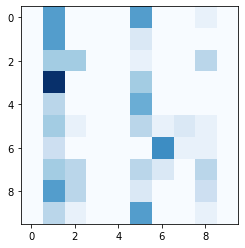

In [12]:
cm=confusion_matrix(y_test,y_pred)
print(cm)
plt.imshow(cm,cmap=plt.cm.Blues)

La maggior parte delle tracce vengono classificate come 1 o 5

In [13]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo_1,normalize=True) 
# Addestramento classificatore con una Support Vector machine
clf= SVC(kernel='rbf', class_weight='balanced') #inizializzo la SVM
clf = clf.fit(X_train, y_train) #addestro il classificatore
y_pred = clf.predict(X_test)
# classification report
print(classification_report(y_test,y_pred)) #accuracy 0.35

              precision    recall  f1-score   support

           0       0.41      0.41      0.41        17
           1       0.21      0.30      0.25        10
           2       0.50      0.47      0.48        15
           3       0.47      0.37      0.41        19
           4       0.08      0.09      0.09        11
           5       0.25      0.43      0.32        14
           6       1.00      0.71      0.83        14
           7       0.31      0.21      0.25        19
           8       0.40      0.24      0.30        17
           9       0.19      0.29      0.23        14

    accuracy                           0.35       150
   macro avg       0.38      0.35      0.36       150
weighted avg       0.39      0.35      0.36       150



In [14]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo_2,normalize=True) 
# Addestramento classificatore con una Support Vector machine
clf= SVC(kernel='rbf', class_weight='balanced') #inizializzo la SVM
clf = clf.fit(X_train, y_train) #addestro il classificatore
y_pred = clf.predict(X_test)
# classification report
print(classification_report(y_test,y_pred)) #accuracy 0.29

              precision    recall  f1-score   support

           0       0.50      0.24      0.32        17
           1       0.07      0.30      0.12        10
           2       0.42      0.53      0.47        15
           3       0.38      0.16      0.22        19
           4       0.21      0.27      0.24        11
           5       0.20      0.14      0.17        14
           6       0.75      0.64      0.69        14
           7       0.00      0.00      0.00        19
           8       0.43      0.35      0.39        17
           9       0.27      0.43      0.33        14

    accuracy                           0.29       150
   macro avg       0.32      0.31      0.29       150
weighted avg       0.33      0.29      0.29       150



In [15]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo_3,normalize=True) 
# Addestramento classificatore con una Support Vector machine
clf= SVC(kernel='rbf', class_weight='balanced') #inizializzo la SVM
clf = clf.fit(X_train, y_train) #addestro il classificatore
y_pred = clf.predict(X_test)
# classification report
print(classification_report(y_test,y_pred)) #accuracy 0.31

              precision    recall  f1-score   support

           0       0.50      0.18      0.26        17
           1       0.10      0.30      0.15        10
           2       0.47      0.53      0.50        15
           3       0.40      0.42      0.41        19
           4       0.27      0.27      0.27        11
           5       0.22      0.14      0.17        14
           6       0.75      0.64      0.69        14
           7       0.00      0.00      0.00        19
           8       0.40      0.35      0.38        17
           9       0.20      0.36      0.26        14

    accuracy                           0.31       150
   macro avg       0.33      0.32      0.31       150
weighted avg       0.34      0.31      0.31       150



In [16]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo_4,normalize=True) 
# Addestramento classificatore con una Support Vector machine
clf= SVC(kernel='rbf', class_weight='balanced') #inizializzo la SVM
clf = clf.fit(X_train, y_train) #addestro il classificatore
y_pred = clf.predict(X_test)
# classification report
print(classification_report(y_test,y_pred)) #accuracy 0.51

              precision    recall  f1-score   support

           0       1.00      0.29      0.45        17
           1       0.36      0.50      0.42        10
           2       0.57      0.53      0.55        15
           3       0.56      0.53      0.54        19
           4       0.47      0.64      0.54        11
           5       0.31      0.36      0.33        14
           6       0.73      0.79      0.76        14
           7       0.53      0.42      0.47        19
           8       0.50      0.35      0.41        17
           9       0.46      0.86      0.60        14

    accuracy                           0.51       150
   macro avg       0.55      0.53      0.51       150
weighted avg       0.56      0.51      0.51       150



[[ 5  0  0  0  1  0  0  2  0  9]
 [ 0  5  0  3  2  0  0  0  0  0]
 [ 0  1  8  1  0  2  1  1  1  0]
 [ 0  4  3 10  0  0  1  0  0  1]
 [ 0  2  0  0  7  1  0  1  0  0]
 [ 0  0  2  0  3  5  0  1  1  2]
 [ 0  0  0  1  0  0 11  0  2  0]
 [ 0  0  1  2  1  4  0  8  2  1]
 [ 0  1  0  1  1  3  2  2  6  1]
 [ 0  1  0  0  0  1  0  0  0 12]]


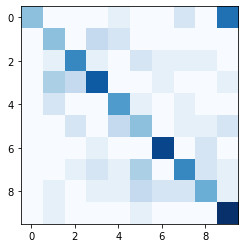

In [17]:
cm=confusion_matrix(y_test,y_pred)
print(cm)
plt.imshow(cm,cmap=plt.cm.Blues)

La combinazione di tutti i feature extractor sviluppano un classificatore decente. Tuttavia si nota una forte classificazione di 0 come 9 (falsi 9).

# zcr_zero
Al contrario della versione precedente, considero anche quando il segnale "tocca" lo zero. In particolare ogni coppia di 0 viene valutata come +1. In breve:
+ 2: cambio di segno pieno, vale come +1
+ 1: cambio di segno allo zero, vale come +0.5 ma arrotondo alla parte intera
+ 0: nessun cambio di segno, vale come +0

In [18]:
def zcr_zero(input):
    last=input[-1]
    lag=shift(input,shift=-1,cval=last) #il numero in ultima posizione viene confrontato con sè stesso
    diff=abs(np.sign(input)-np.sign(lag))
    n_count=collections.Counter(diff)
    return np.array([ int(n_count[2]+n_count[1]*0.5) ]) #considero, oltre al cambio segno "pieno", ogni coppia di 0 come un aumento unitario

In [19]:
def combo_zero(input):
  return np.concatenate((zcr_zero(input),duration(input),energy(input),sdev(input),aavg(input)))

In [20]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=zcr_zero) 
# Addestramento classificatore con una Support Vector machine
clf= SVC(kernel='rbf', class_weight='balanced') #inizializzo la SVM
clf = clf.fit(X_train, y_train) #addestro il classificatore
y_pred = clf.predict(X_test)
# classification report
print(classification_report(y_test,y_pred)) #accuracy 0.26

              precision    recall  f1-score   support

           0       0.23      0.53      0.32        17
           1       0.19      0.80      0.30        10
           2       0.28      0.33      0.30        15
           3       0.00      0.00      0.00        19
           4       0.00      0.00      0.00        11
           5       0.17      0.07      0.10        14
           6       0.75      0.64      0.69        14
           7       0.00      0.00      0.00        19
           8       0.20      0.12      0.15        17
           9       0.26      0.36      0.30        14

    accuracy                           0.26       150
   macro avg       0.21      0.29      0.22       150
weighted avg       0.20      0.26      0.21       150



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 9  5  1  0  0  2  0  0  0  0]
 [ 1  8  0  0  0  0  0  0  0  1]
 [ 3  2  5  0  0  1  0  0  2  2]
 [ 2 14  1  0  0  0  0  0  0  2]
 [ 4  4  0  0  0  0  0  0  0  3]
 [ 3  2  3  0  0  1  1  2  0  2]
 [ 0  2  0  0  0  0  9  1  1  1]
 [ 4  2  2  0  0  2  2  0  4  3]
 [ 6  4  5  0  0  0  0  0  2  0]
 [ 7  0  1  0  0  0  0  0  1  5]]


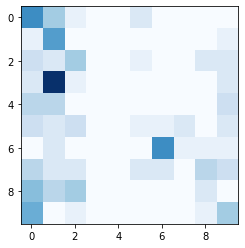

In [21]:
cm=confusion_matrix(y_test,y_pred)
print(cm)
plt.imshow(cm,cmap=plt.cm.Blues)

In [22]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo_zero,normalize=True) 
# Addestramento classificatore con una Support Vector machine
clf= SVC(kernel='rbf', class_weight='balanced') #inizializzo la SVM
clf = clf.fit(X_train, y_train) #addestro il classificatore
y_pred = clf.predict(X_test)
# classification report
print(classification_report(y_test,y_pred)) #accuracy 0.58

              precision    recall  f1-score   support

           0       0.81      0.76      0.79        17
           1       0.29      0.50      0.37        10
           2       0.57      0.53      0.55        15
           3       0.65      0.58      0.61        19
           4       0.47      0.73      0.57        11
           5       0.36      0.29      0.32        14
           6       0.80      0.86      0.83        14
           7       0.56      0.53      0.54        19
           8       0.67      0.35      0.46        17
           9       0.62      0.71      0.67        14

    accuracy                           0.58       150
   macro avg       0.58      0.58      0.57       150
weighted avg       0.60      0.58      0.58       150



[[13  2  0  0  0  0  0  0  0  2]
 [ 0  5  0  3  2  0  0  0  0  0]
 [ 0  1  8  1  0  2  1  2  0  0]
 [ 0  4  3 11  0  0  0  0  0  1]
 [ 0  2  0  0  8  0  0  1  0  0]
 [ 0  0  2  0  4  4  0  3  0  1]
 [ 0  0  1  0  0  0 12  0  1  0]
 [ 1  1  0  1  1  2  0 10  2  1]
 [ 0  1  0  1  1  3  2  2  6  1]
 [ 2  1  0  0  1  0  0  0  0 10]]


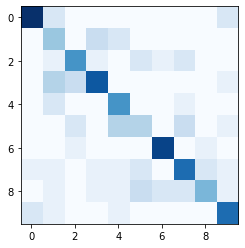

In [23]:
cm=confusion_matrix(y_test,y_pred)
print(cm)
plt.imshow(cm,cmap=plt.cm.Blues)

Miglior classificatore finora, non si ha più il problema dei falsi 9.

# zcr_f_zero
Upgrade di zcr_zero. Ultimo numero del vettore lo confronto con il primo

In [24]:
def zcr_f_zero(input):
    first=input[0]
    lag=shift(input,shift=-1,cval=first)
    diff=abs(np.sign(input)-np.sign(lag))
    n_count=collections.Counter(diff)
    return np.array([ int(n_count[2]+n_count[1]*0.5) ])

In [25]:
def combo_f_zero(input):
  return np.concatenate((zcr_f_zero(input),duration(input),energy(input),sdev(input),aavg(input)))

In [26]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=zcr_f_zero) 
# Addestramento classificatore con una Support Vector machine
clf= SVC(kernel='rbf', class_weight='balanced') #inizializzo la SVM
clf = clf.fit(X_train, y_train) #addestro il classificatore
y_pred = clf.predict(X_test)
# classification report
print(classification_report(y_test,y_pred)) #accuracy 0.26

              precision    recall  f1-score   support

           0       0.23      0.53      0.32        17
           1       0.19      0.80      0.30        10
           2       0.29      0.33      0.31        15
           3       0.00      0.00      0.00        19
           4       0.00      0.00      0.00        11
           5       0.14      0.07      0.10        14
           6       0.75      0.64      0.69        14
           7       0.00      0.00      0.00        19
           8       0.20      0.12      0.15        17
           9       0.26      0.36      0.30        14

    accuracy                           0.26       150
   macro avg       0.21      0.29      0.22       150
weighted avg       0.20      0.26      0.21       150



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 9  5  1  0  0  2  0  0  0  0]
 [ 1  8  0  0  0  0  0  0  0  1]
 [ 3  2  5  0  0  1  0  0  2  2]
 [ 2 14  1  0  0  0  0  0  0  2]
 [ 4  4  0  0  0  0  0  0  0  3]
 [ 3  2  3  0  0  1  1  2  0  2]
 [ 0  2  0  0  0  0  9  1  1  1]
 [ 4  2  2  0  0  2  2  0  4  3]
 [ 6  4  5  0  0  0  0  0  2  0]
 [ 7  0  0  0  0  1  0  0  1  5]]


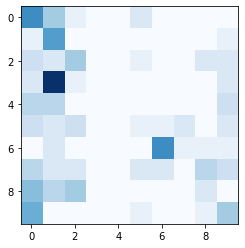

In [27]:
cm=confusion_matrix(y_test,y_pred)
print(cm)
plt.imshow(cm,cmap=plt.cm.Blues)

In [28]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo_f_zero,normalize=True) 
# Addestramento classificatore con una Support Vector machine
clf= SVC(kernel='rbf', class_weight='balanced') #inizializzo la SVM
clf = clf.fit(X_train, y_train) #addestro il classificatore
y_pred = clf.predict(X_test)
# classification report
print(classification_report(y_test,y_pred)) #accuracy 0.58

              precision    recall  f1-score   support

           0       0.81      0.76      0.79        17
           1       0.31      0.50      0.38        10
           2       0.57      0.53      0.55        15
           3       0.61      0.58      0.59        19
           4       0.47      0.73      0.57        11
           5       0.36      0.29      0.32        14
           6       0.80      0.86      0.83        14
           7       0.56      0.53      0.54        19
           8       0.67      0.35      0.46        17
           9       0.62      0.71      0.67        14

    accuracy                           0.58       150
   macro avg       0.58      0.58      0.57       150
weighted avg       0.59      0.58      0.58       150



[[13  2  0  0  0  0  0  0  0  2]
 [ 0  5  0  3  2  0  0  0  0  0]
 [ 0  1  8  1  0  2  1  2  0  0]
 [ 0  4  3 11  0  0  0  0  0  1]
 [ 0  2  0  0  8  0  0  1  0  0]
 [ 0  0  2  0  4  4  0  3  0  1]
 [ 0  0  1  0  0  0 12  0  1  0]
 [ 1  1  0  1  1  2  0 10  2  1]
 [ 0  0  0  2  1  3  2  2  6  1]
 [ 2  1  0  0  1  0  0  0  0 10]]


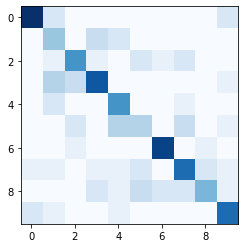

In [29]:
cm=confusion_matrix(y_test,y_pred)
print(cm)
plt.imshow(cm,cmap=plt.cm.Blues)

Stesse performance di zcr_zero

# Considerazioni finali
+ Miglior feature extractor: *combo_zero()* dato dalla combinazione di *zcr_zero* e altre funzioni (accuracy 0.58). La stessa performance è raggiunta da *combo_f_zero*.
+ Sulla base del punto precedente, non sembra influire troppo la scelta del confronto per l'ultimo numero. Risulta essere più significativo il modo con cui si contano gli zeri. Nel complesso si notato migliori performance per i ZCR non base.
+ Algoritmi ZCR non raggiungono prestazioni eccezionali